In [1]:
## Import Section

import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
from scipy import signal, fft, sparse

import itertools
import sys
import os

In [2]:
## Defining Basic Functions

def plotgray(im, cmap='gray', size=None):
    fig = plt.figure(figsize=size)
    plt.imshow(im, cmap=cmap)
    plt.show()

def plot3ch(im, size=None):
    fig = plt.figure(figsize=size)
    plt.imshow(im)
    plt.show()

def resize(im, scale):
    h, w = im.shape[:2]
    return sk.transform.resize(im, (int(h*scale), int(w*scale)))

def normalize_clip(im):
    return np.minimum(np.maximum(im, 0), 1)

def normalize(im):
    return (im-np.min(im))/(np.max(im)-np.min(im))

def rgb2gray(rgb):
    return rgb.dot([0.2989, 0.5870, 0.1140])

# crop the borders of a given image by `ratio` percent
def crop_with_percent(im, ratio=0.4):
    h, w = im.shape[:2]
    return im[int(h*(ratio/2)):int(h*(1-ratio/2)), int(w*(ratio/2)):int(w*(1-ratio/2))]

# sum of squared differences metric
def ssd(im_1, im_2):
    return np.sum((im_1-im_2)**2)

# normalized cross correlation metric
def ncc(im_1, im_2):
    return -np.sum(im_1*im_2)/np.sqrt(np.sum(im_1**2))/np.sqrt(np.sum(im_2**2))

# rotate an image by `angle` degrees counterclockwise about `center`
def rotate(im, angle, center=None):
    h, w = im.shape[:2]
    if center is None:
        center = (w // 2, h // 2)
    mat = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
    return cv2.warpAffine(im, mat, (w, h))

# translate an image `tx` to the right, `ty` down
def translate(im, tx, ty, size=None):
    h, w = im.shape[:2]
    if size == None:
        size = (h, w)
    mat = translation_matrix = np.array([
        [1, 0, tx],
        [0, 1, ty]
    ], dtype=np.float32)
    return cv2.warpAffine(im, mat, (size[1], size[0]))

def get_gaussian_kernel_2d(ksize, sigma):
    # get 1d kernel as a 1 column matrix
    k1d = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
    return k1d @ k1d.T

def get_impulse_kernel(ksize):
    k = np.zeros((ksize, ksize))
    k[ksize//2, ksize//2] = 1
    return k

def get_dx_op():
    dx_op = np.tile(np.array([-1, 0, 1])[None,:], (2, 1))/2
    return dx_op

def get_dy_op():
    dy_op = np.tile(np.array([-1, 0, 1])[:, None], (1, 2))/2
    return dy_op

def convolve3ch(im, kernel, mode):
    r, g, b = im[:, :, 0], im[:, :, 1], im[:, :, 2]
    r_f = signal.convolve2d(r, kernel, mode=mode)
    g_f = signal.convolve2d(g, kernel, mode=mode)
    b_f = signal.convolve2d(b, kernel, mode=mode)
    im_f = np.dstack((r_f, g_f, b_f))
    return im_f

def fft(im):
    return np.fft.fftshift(np.fft.fft2(im))

def fft_log_abs(im):
    return np.log(np.abs(np.fft.fftshift(np.fft.fft2(im))))

In [3]:
## Part 2.1

# read in the image
input_dir = "./samples/"
output_dir = "./output/"
im_name = "toy_problem.png"

input_file = input_dir+im_name
im_s = skio.imread(input_file)
im_s = sk.img_as_float(im_s)
h, w = im_s.shape[:2]

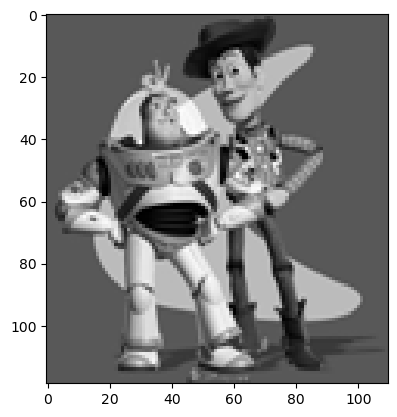

In [4]:
# construct sparse matrix A and vector b
tot_eq, tot_var = 0, h*w
im2var = np.arange(tot_var).reshape((h, w))
data, row_id, col_id, b = [], [], [], []

for x in range(w-1):
    for y in range(h):
        row_id.append(tot_eq); col_id.append(im2var[y, x+1]); data.append(1)
        row_id.append(tot_eq); col_id.append(im2var[y, x]); data.append(-1)
        b.append(im_s[y, x+1]-im_s[y, x])
        tot_eq += 1
        
for x in range(w):
    for y in range(h-1):      
        row_id.append(tot_eq); col_id.append(im2var[y+1, x]); data.append(1)
        row_id.append(tot_eq); col_id.append(im2var[y, x]); data.append(-1)
        b.append(im_s[y+1, x]-im_s[y, x])
        tot_eq += 1
        
row_id.append(tot_eq); col_id.append(im2var[0, 0]); data.append(1)
b.append(im_s[0, 0])
tot_eq += 1

# solve for v
A = sparse.csr_matrix((data, (row_id, col_id)), (tot_eq, tot_var))
result = sparse.linalg.lsqr(A, b)[0]
im_v = result.reshape((h, w))

plotgray(im_v)
plt.imsave(output_dir+"toy_result.jpg", im_v, cmap="gray")

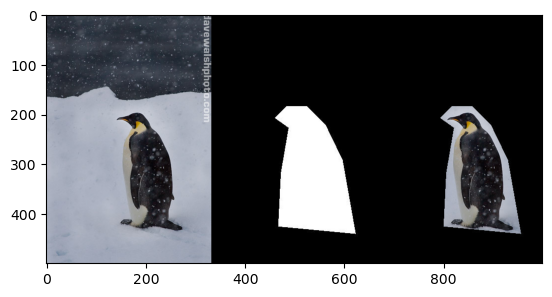

In [48]:
## Part 2.2
# example 1

input_dir = "./samples/example1/"
output_dir = "./output/example1/"

# read in the source image
im_name = "penguin.jpg"
input_file = input_dir+im_name
im_s = skio.imread(input_file)
im_s = sk.img_as_float(im_s)

# read in the target image
im_name = "im3.jpg"
input_file = input_dir+im_name
im_t = skio.imread(input_file)
im_t = sk.img_as_float(im_t)

# read in the mask
im_name = "mask.jpg"
input_file = input_dir+im_name
mask = skio.imread(input_file)
mask = sk.img_as_float(mask)

# show masked source image
masked_im_s = np.hstack((im_s, mask, im_s*mask))
plot3ch(masked_im_s)
plt.imsave(output_dir+"source_region.jpg", masked_im_s, cmap="gray")

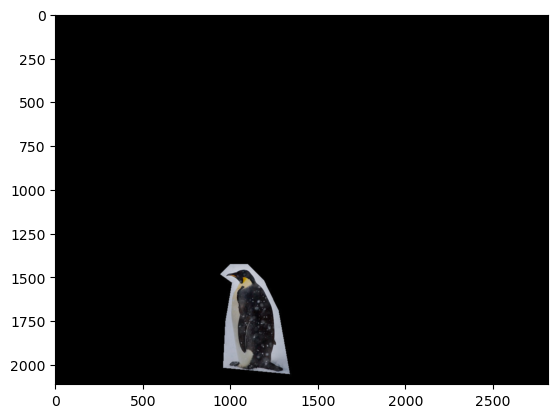

In [49]:
# align the source image
f = open(input_dir+"transform.txt", 'r')
rdl = f.readline().strip().split(',')
tx, ty = int(rdl[1]), int(rdl[2])
rdl = f.readline().strip().split(',')
scale = float(rdl[1])
f.close()
im_s_ = resize(im_s, scale)
mask_ = resize(mask, scale)
im_s_ = translate(im_s_, tx, ty, im_t.shape)
mask_ = translate(mask_, tx, ty, im_t.shape)

aligned_im_s = im_s_*mask_
plot3ch(aligned_im_s)
plt.imsave(output_dir+"aligned_source_region.jpg", aligned_im_s, cmap="gray")

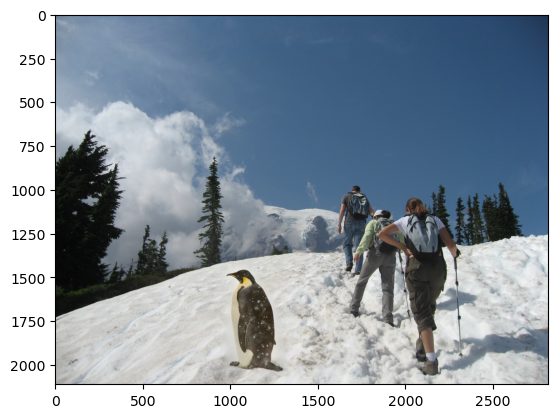

In [53]:
# possion blending for 1ch image
def possion_blending(im_s, im_t, mask):
    
    # construct sparse matrix A and vector b
    h, w = im_s.shape[:2]
    tot_eq, tot_var = 0, int(np.sum(mask))
    im2var = np.zeros(im_s.shape[:2])
    im2var[mask] = np.arange(tot_var)
    data, row_id, col_id, b = [], [], [], []

    dx, dy = [0, 1, 0, -1], [1, 0, -1, 0]
    for x in range(w):
        for y in range(h):
            if mask[y, x] == False:
                continue
            for i in range(4):
                row_id.append(tot_eq); col_id.append(im2var[y, x]); data.append(1)
                if mask[y+dy[i], x+dx[i]] == 1:
                    # inside the source region
                    row_id.append(tot_eq); col_id.append(im2var[y+dy[i], x+dx[i]]); data.append(-1)
                    b.append(im_s[y, x]-im_s[y+dy[i], x+dx[i]])
                else: 
                    # outside the source region: b set to s_i-s_j+t_j
                    b.append(im_s[y, x]-im_s[y+dy[i], x+dx[i]]+im_t[y+dy[i], x+dx[i]])
                tot_eq += 1

    # solve for v
    A = sparse.csr_matrix((data, (row_id, col_id)), (tot_eq, tot_var))
    result = sparse.linalg.lsqr(A, b)[0]
    im_v = im_t
    im_v[mask] = result
    
    return im_v

mask__ = mask_[:, :, 0]>0.9 # change dtype to bool. Note that there might be values like 0.98 and 0.02.
# split color channels
r_s, g_s, b_s = im_s_[:, :, 0], im_s_[:, :, 1], im_s_[:, :, 2]
r_t, g_t, b_t = im_t[:, :, 0], im_t[:, :, 1], im_t[:, :, 2]

r_v = possion_blending(r_s, r_t, mask__)
g_v = possion_blending(g_s, g_t, mask__)
b_v = possion_blending(b_s, b_t, mask__)

im_v = np.dstack((r_v, g_v, b_v))
plot3ch(im_v)
plt.imsave(output_dir+"result.jpg", im_v)

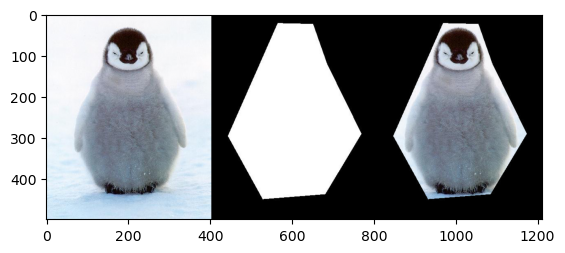

In [55]:
# example 2: failure

input_dir = "./samples/example2/"
output_dir = "./output/example2/"

# read in the source image
im_name = "penguin-chick.jpeg"
input_file = input_dir+im_name
im_s = skio.imread(input_file)
im_s = sk.img_as_float(im_s)

# read in the target image
im_name = "im2.jpg"
input_file = input_dir+im_name
im_t = skio.imread(input_file)
im_t = sk.img_as_float(im_t)

# read in the mask
im_name = "mask.jpg"
input_file = input_dir+im_name
mask = skio.imread(input_file)
mask = sk.img_as_float(mask)

# show masked source image
masked_im_s = np.hstack((im_s, mask, im_s*mask))
plot3ch(masked_im_s)
plt.imsave(output_dir+"source_region.jpg", masked_im_s, cmap="gray")

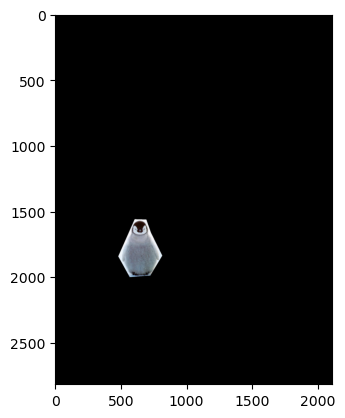

In [56]:
# align the source image
f = open(input_dir+"transform.txt", 'r')
rdl = f.readline().strip().split(',')
tx, ty = int(rdl[1]), int(rdl[2])
rdl = f.readline().strip().split(',')
scale = float(rdl[1])
f.close()
im_s_ = resize(im_s, scale)
mask_ = resize(mask, scale)
im_s_ = translate(im_s_, tx, ty, im_t.shape)
mask_ = translate(mask_, tx, ty, im_t.shape)

aligned_im_s = im_s_*mask_
plot3ch(aligned_im_s)
plt.imsave(output_dir+"aligned_source_region.jpg", aligned_im_s, cmap="gray")

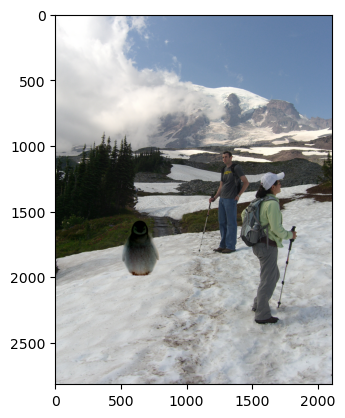

In [60]:
mask__ = mask_[:, :, 0]>0.9 # change dtype to bool. Note that there might be values like 0.98 and 0.02.
# split color channels
r_s, g_s, b_s = im_s_[:, :, 0], im_s_[:, :, 1], im_s_[:, :, 2]
r_t, g_t, b_t = im_t[:, :, 0], im_t[:, :, 1], im_t[:, :, 2]

r_v = possion_blending(r_s, r_t, mask__)
g_v = possion_blending(g_s, g_t, mask__)
b_v = possion_blending(b_s, b_t, mask__)

im_v = np.dstack((r_v, g_v, b_v))
plot3ch(normalize_clip(im_v))
plt.imsave(output_dir+"result.jpg", normalize_clip(im_v))

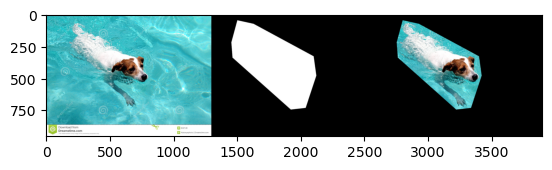

In [64]:
# example 3

input_dir = "./samples/example3/"
output_dir = "./output/example3/"

# read in the source image
im_name = "swimming-dog.jpg"
input_file = input_dir+im_name
im_s = skio.imread(input_file)
im_s = sk.img_as_float(im_s)

# read in the target image
im_name = "magma-pool.jpg"
input_file = input_dir+im_name
im_t = skio.imread(input_file)
im_t = sk.img_as_float(im_t)

# read in the mask
im_name = "mask.jpg"
input_file = input_dir+im_name
mask = skio.imread(input_file)
mask = sk.img_as_float(mask)

# show masked source image
masked_im_s = np.hstack((im_s, mask, im_s*mask))
plot3ch(masked_im_s)
plt.imsave(output_dir+"source_region.jpg", masked_im_s, cmap="gray")

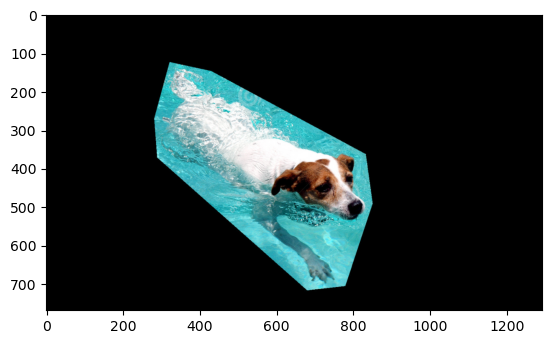

In [65]:
# align the source image
f = open(input_dir+"transform.txt", 'r')
rdl = f.readline().strip().split(',')
tx, ty = int(rdl[1]), int(rdl[2])
rdl = f.readline().strip().split(',')
scale = float(rdl[1])
f.close()
im_s_ = resize(im_s, scale)
mask_ = resize(mask, scale)
im_s_ = translate(im_s_, tx, ty, im_t.shape)
mask_ = translate(mask_, tx, ty, im_t.shape)

aligned_im_s = im_s_*mask_
plot3ch(aligned_im_s)
plt.imsave(output_dir+"aligned_source_region.jpg", aligned_im_s, cmap="gray")

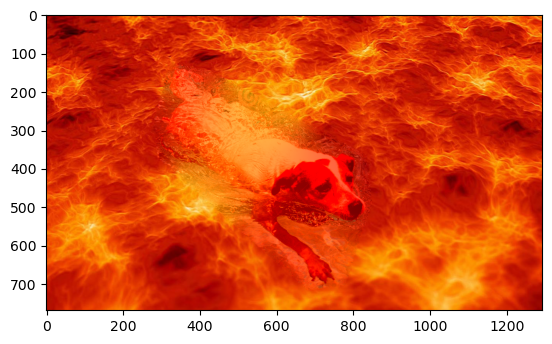

In [66]:
mask__ = mask_[:, :, 0]>0.9 # change dtype to bool. Note that there might be values like 0.98 and 0.02.
# split color channels
r_s, g_s, b_s = im_s_[:, :, 0], im_s_[:, :, 1], im_s_[:, :, 2]
r_t, g_t, b_t = im_t[:, :, 0], im_t[:, :, 1], im_t[:, :, 2]

r_v = possion_blending(r_s, r_t, mask__)
g_v = possion_blending(g_s, g_t, mask__)
b_v = possion_blending(b_s, b_t, mask__)

im_v = np.dstack((r_v, g_v, b_v))
plot3ch(normalize_clip(im_v))
plt.imsave(output_dir+"result.jpg", normalize_clip(im_v))

In [70]:
## Bells & Whistles: Mixed Gradients

# mixed possion blending for 1ch image
def mixed_possion_blending(im_s, im_t, mask):
    
    # construct sparse matrix A and vector b
    h, w = im_s.shape[:2]
    tot_eq, tot_var = 0, int(np.sum(mask))
    im2var = np.zeros(im_s.shape[:2])
    im2var[mask] = np.arange(tot_var)
    data, row_id, col_id, b = [], [], [], []

    dx, dy = [0, 1, 0, -1], [1, 0, -1, 0]
    for x in range(w):
        for y in range(h):
            if mask[y, x] == False:
                continue
            for i in range(4):
                row_id.append(tot_eq); col_id.append(im2var[y, x]); data.append(1)
                # compute d_ij
                if abs(im_s[y, x]-im_s[y+dy[i], x+dx[i]]) > abs(im_t[y, x]-im_t[y+dy[i], x+dx[i]]):
                    d_ij = im_s[y, x]-im_s[y+dy[i], x+dx[i]]
                else:
                    d_ij = im_t[y, x]-im_t[y+dy[i], x+dx[i]]
                if mask[y+dy[i], x+dx[i]] == 1:
                    # inside the source region
                    row_id.append(tot_eq); col_id.append(im2var[y+dy[i], x+dx[i]]); data.append(-1)
                    b.append(d_ij)
                else: 
                    # outside the source region: b set to s_i-s_j+t_j
                    b.append(d_ij+im_t[y+dy[i], x+dx[i]])
                tot_eq += 1

    # solve for v
    A = sparse.csr_matrix((data, (row_id, col_id)), (tot_eq, tot_var))
    result = sparse.linalg.lsqr(A, b)[0]
    im_v = im_t
    im_v[mask] = result
    
    return im_v

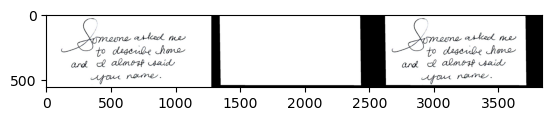

In [74]:
# example 4

input_dir = "./samples/example4/"
output_dir = "./output/example4/"

# read in the source image
im_name = "handwriting.jpg"
input_file = input_dir+im_name
im_s = skio.imread(input_file)
im_s = sk.img_as_float(im_s)

# read in the target image
im_name = "wall.jpg"
input_file = input_dir+im_name
im_t = skio.imread(input_file)
im_t = sk.img_as_float(im_t)

# read in the mask
im_name = "mask.jpg"
input_file = input_dir+im_name
mask = skio.imread(input_file)
mask = sk.img_as_float(mask)

# show masked source image
masked_im_s = np.hstack((im_s, mask, im_s*mask))
plot3ch(masked_im_s)
plt.imsave(output_dir+"source_region.jpg", masked_im_s, cmap="gray")

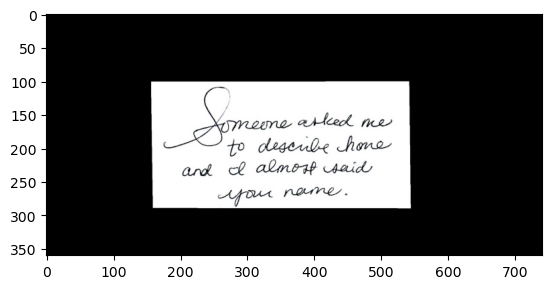

In [75]:
# align the source image
f = open(input_dir+"transform.txt", 'r')
rdl = f.readline().strip().split(',')
tx, ty = int(rdl[1]), int(rdl[2])
rdl = f.readline().strip().split(',')
scale = float(rdl[1])
f.close()
im_s_ = resize(im_s, scale)
mask_ = resize(mask, scale)
im_s_ = translate(im_s_, tx, ty, im_t.shape)
mask_ = translate(mask_, tx, ty, im_t.shape)

aligned_im_s = im_s_*mask_
plot3ch(aligned_im_s)
plt.imsave(output_dir+"aligned_source_region.jpg", aligned_im_s, cmap="gray")

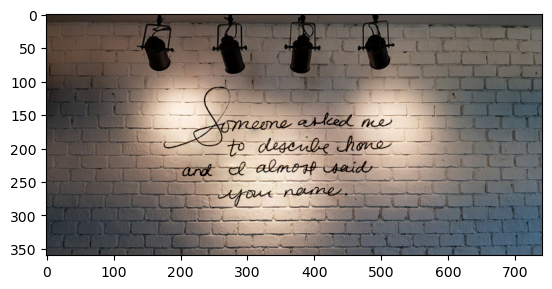

In [76]:
mask__ = mask_[:, :, 0]>0.9 # change dtype to bool. Note that there might be values like 0.98 and 0.02.
# split color channels
r_s, g_s, b_s = im_s_[:, :, 0], im_s_[:, :, 1], im_s_[:, :, 2]
r_t, g_t, b_t = im_t[:, :, 0], im_t[:, :, 1], im_t[:, :, 2]

r_v = mixed_possion_blending(r_s, r_t, mask__)
g_v = mixed_possion_blending(g_s, g_t, mask__)
b_v = mixed_possion_blending(b_s, b_t, mask__)

im_v = np.dstack((r_v, g_v, b_v))
plot3ch(normalize_clip(im_v))
plt.imsave(output_dir+"result.jpg", normalize_clip(im_v))